In [105]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn import model_selection
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import spectral_embedding
from sklearn.metrics import silhouette_score
from scipy import linalg
from scipy.sparse.csgraph import laplacian
from scipy.spatial import distance
from tslearn.metrics import cdist_dtw


# Generate data

In [106]:
def exp_model(x, a, b, lambda_):
    return a - b*np.exp(-lambda_*x)

In [124]:
# Initialize the random number generator
np.random.seed(24)

# Define the parameters
a = [0.8,0.7,0.8]
b = [0.3,0.2,0.3]
lambda_ = [0.1,0.2,0.5]
scale_param = 60
nb_students = 400

# Generate dummy student data
proba_dataset = pd.DataFrame({'user_id': [], 'attempt': [], 'correct_predictions': [], 'group':[]})
max_attempt = (np.rint(np.random.exponential(scale_param, nb_students))).astype(
    int)  # We saw that the number of attempts per student is exponentially distributed
for i in range(len(max_attempt)):
    user_id = np.repeat(i, max_attempt[i])
    attempt = np.arange(max_attempt[i])
    e = np.random.randn(max_attempt[i]) * (
                np.random.randn() * 0.1 + 0.1)  # Generate some noise with a different variance for each student
    group = random.randint(0, 2) #Choose parameter index
    correct_predictions = exp_model(attempt, a[group], b[group], lambda_[group]) + e  # Generate the probability of success for each attempt

    proba_dataset = pd.concat([proba_dataset, pd.DataFrame(
        {'user_id': user_id, 'attempt': attempt, 'correct_predictions': correct_predictions, 'group' : np.repeat(group, len(user_id))})], ignore_index=True)

proba_dataset

,user_id,attempt,correct_predictions,group
0,0.0,0.0,0.750268,2.0
1,0.0,1.0,0.893088,2.0
2,0.0,2.0,0.563473,2.0
3,0.0,3.0,0.870792,2.0
4,0.0,4.0,0.806884,2.0
...,...,...,...,...
25952,398.0,34.0,0.827689,2.0
25953,399.0,0.0,0.594630,1.0
25954,399.0,1.0,0.154767,1.0
25955,399.0,2.0,0.773804,1.0


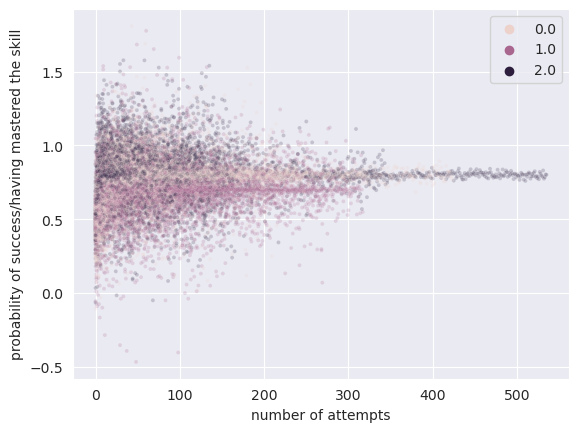

In [125]:
sns.scatterplot(data=proba_dataset, x = proba_dataset.attempt, y = proba_dataset.correct_predictions, hue='group', alpha=0.2, s=8)
plt.xlabel('number of attempts')
plt.ylabel('probability of success/having mastered the skill')
plt.legend()
plt.show()

In [126]:
def get_time_series(df):
    """
    reshapes DataFrame from long to wide and returns an np.array
    :param df: pd.DataFrame with data in long format
    :return: np.array with reshaped data
    """
    display(df.user_id.nunique())
    df_array = (df.groupby('user_id').agg({'correct_predictions': lambda x: list(x)}))
    display(df_array)

    #data = pd.DataFrame(df_array["correct_predictions"].values.tolist()).values
    return df_array

data = get_time_series(proba_dataset)
data.shape

#data = data['correct_predictions'].values.tolist()

395

,correct_predictions
user_id,
0.0,"[0.7502681738025596, 0.8930879824690199, 0.563..."
1.0,"[0.5532977238384346, 0.7810293271828399, 0.259..."
2.0,"[0.4936002872308821, 0.6127126595479685, 0.690..."
3.0,"[0.6303229248263476, 0.5205924883384524, 0.467..."
4.0,"[0.6153586172945515, 0.3001332153207852, 0.584..."
...,...
395.0,"[0.39105893468179154, 0.637560604325882, 0.824..."
396.0,"[0.5371066478239027, 0.7549117883856126, 0.736..."
397.0,"[0.5372267650788206, 0.6057258747475102, 0.691..."


(395, 1)

# Clustering with Dynamic Time Warping

In [127]:
def get_adjacency(S, connectivity='full'):
    """
    Computes the adjacency matrix
    :param S: np array of similarity matrix
    :param connectivity: type of connectivity
    :return: adjacency matrix
    """

    if(connectivity=='full'):
        adjacency = S
    elif(connectivity=='epsilon'):
        epsilon = 0.5
        adjacency = np.where(S > epsilon, 1, 0)
    else:
        raise RuntimeError('Method not supported')

    return adjacency

def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues

    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)  #Compute the unnormalized graph laplacian
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted

def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]

    :param n_clusters_list: List of number of clusters to explore
    :param metric_dictionary:
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(3, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1

def get_heuristics_spectral(W, n_clusters_list, plot=True):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering

    :param W: np array of adjacency matrix
    :param n_clusters_list: List of number of clusters to explore
    :plot: bool, plot the metrics if true
    """
    silhouette_list = []
    eigengap_list = []

    df_labels = pd.DataFrame()

    for k in n_clusters_list:

        kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, k)
        y_pred = kmeans.labels_
        df_labels[str(k)] = y_pred

        if k == 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)


    metric_dictionary = {
                         'Silhouette': silhouette_list,
                         'Eigengap': eigenvals_sorted,
                        }

    if(plot):
        plot_metrics(n_clusters_list, metric_dictionary)
        return df_labels
    else:
        return df_labels, metric_dictionary

def get_distance_matrix(X, metric='euclidean', window=2):
    """
    calculates distance matrix given a metric
    :param X: np.array with students' time-series
    :param metric: str distance metric to compute
    :param window: int for DTW
    :return: np.array with distance matrix
    """
    #norms = np.linalg.norm(X, axis=1)
    #data_normalized = X / norms[:, np.newaxis]

    X['normalized_list'] = X['correct_predictions'].apply(lambda x: [i/np.linalg.norm(x) for i in x])
    display(X)
    data_normalized = X['normalized_list'].values.tolist()
    display(data_normalized)

    #data_normalized = pd.DataFrame(X['normalized_list'].values.tolist()).values

    if metric == 'dtw':
        distance_matrix = cdist_dtw(data_normalized,
                                    global_constraint='sakoe_chiba',
                                    sakoe_chiba_radius=window)
    else:
        distance_vector = distance.pdist(data_normalized, metric)
        distance_matrix = distance.squareform(distance_vector)
    return distance_matrix

def get_affinity_matrix(D, gamma=1):
    """
    calculates affinity matrix from distance matrix
    :param D: np.array distance matrix
    :param gamma: float coefficient for Gaussian Kernel
    :return:
    """
    S = np.exp(-gamma * D ** 2)
    return S

In [128]:
D = get_distance_matrix(data, metric='dtw', window=10)
#S = get_affinity_matrix(D)
#W = get_adjacency(S)
#n_cluster_list = range(1, 10)
#df_labels = get_heuristics_spectral(W, n_cluster_list)

,correct_predictions,normalized_list
user_id,,
0.0,"[0.7502681738025596, 0.8930879824690199, 0.563...","[0.06785239992241335, 0.08076867054784097, 0.0..."
1.0,"[0.5532977238384346, 0.7810293271828399, 0.259...","[0.0767253671235267, 0.10830473229968095, 0.03..."
2.0,"[0.4936002872308821, 0.6127126595479685, 0.690...","[0.026694404713819488, 0.03313612275027633, 0...."
3.0,"[0.6303229248263476, 0.5205924883384524, 0.467...","[0.25408692930223065, 0.20985393608548558, 0.1..."
4.0,"[0.6153586172945515, 0.3001332153207852, 0.584...","[0.17043164743185954, 0.08312583410472922, 0.1..."
...,...,...
395.0,"[0.39105893468179154, 0.637560604325882, 0.824...","[0.03819881206050839, 0.06227720566375924, 0.0..."
396.0,"[0.5371066478239027, 0.7549117883856126, 0.736...","[0.08247639795325641, 0.11592186641285028, 0.1..."
397.0,"[0.5372267650788206, 0.6057258747475102, 0.691...","[0.10405914449962762, 0.11732720784726111, 0.1..."


[[0.06785239992241335,
  0.08076867054784097,
  0.05095914944156196,
  0.07875223727044932,
  0.07297257639229214,
  0.04899888161501444,
  0.08763582123692394,
  0.0677164629908636,
  0.06656565370768219,
  0.06756504934492494,
  0.08534202001698345,
  0.038557355434758925,
  0.07600186583250446,
  0.06080490883081904,
  0.047355028780703017,
  0.0619086637282105,
  0.06863251729598578,
  0.0717938851597501,
  0.05221281630165646,
  0.07566431022195251,
  0.06714125625156976,
  0.04635153440105768,
  0.07074142963037845,
  0.07670213392089434,
  0.052306358012688584,
  0.09658330856964492,
  0.1033867360887434,
  0.027065375533895347,
  0.07011010087149135,
  0.04977109795437866,
  0.04491699635224393,
  0.08809257339376823,
  0.06726321233378037,
  0.06456584764632269,
  0.08099186217822513,
  0.0659666963783535,
  0.044119944170933366,
  0.06333539308166289,
  0.09515012592100956,
  0.07168813781671014,
  0.08451767784855208,
  0.06859998823910388,
  0.04172895138270483,
  0.0461526

In [129]:
S = get_affinity_matrix(D)

In [130]:
W = get_adjacency(S)

In [131]:
n_cluster_list = range(1, 10)

/home/constance/Lang/python/anaconda3/envs/MLBD_Calcularis_Sectumsempra/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/constance/Lang/python/anaconda3/envs/MLBD_Calcularis_Sectumsempra/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/constance/Lang/python/anaconda3/envs/MLBD_Calcularis_Sectumsempra/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/constance/Lang/python/anaconda3/envs/MLBD_Calcularis_Sectumsempra/lib/python3.10/site-packages/sklearn/cluster/_

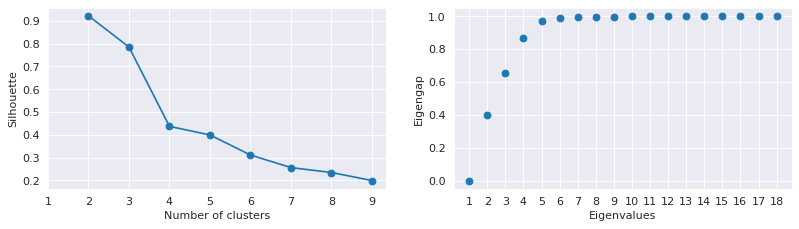

In [132]:
df_labels = get_heuristics_spectral(W, n_cluster_list)